# Qibolab v0.1.6 1Q emulator demo for QuTiP engine

Results updated on: 23 May 2024

## Setting up and using the emulator platform

The emulator is instantiated like any other device platform in Qibolab, by first adding the path to the emulator runcard to the `QIBOLAB_PLATFORMS` environment variable and then using `qibolab.create_platform`. In this tutorial, we will be using the test emulator `default_q0` that can be found in ``/qibolab/tests/emulators/``:

In [1]:
# add directory of emulator platform to QIBOLAB_PLATFORMS environment variable
import pathlib, os
emulator_path = pathlib.Path(os.path.abspath('')).parent/'tests/emulators/'
os.environ["QIBOLAB_PLATFORMS"] = emulator_path.as_posix() 

# create emulator platform as per any other device platform
from qibolab import create_platform
emulator_platform = create_platform("default_q0")

[Qibo 0.2.6|INFO|2024-05-23 18:32:49]: Loading platform ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine
INFO:qibo.config:Loading platform ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine


Similarly, the emulator plays pulse sequences in the same way as any other device platforms. In this tutorial, we will play a simple RX pulse followed by a readout pulse as defined in the runcard on the 'default_q0' single-qubit emulator that we have just initialized:

In [2]:
from qibolab.pulses import PulseSequence

# Extract preset pulses from runcard
pulse_x0 = emulator_platform.create_RX_pulse(qubit=0, start=0)
pulse_r0 = emulator_platform.create_qubit_readout_pulse(qubit=0, start=(170/4.5))

# Add pulses to PulseSequence
sequence = PulseSequence()
sequence.add(pulse_x0)
sequence.add(pulse_r0)

from qibolab.execution_parameters import ExecutionParameters

# Execute the pulse sequence and save the output
options = ExecutionParameters(nshots=1000)
results = emulator_platform.execute_pulse_sequence(sequence, options=options)

[Qibo 0.2.6|INFO|2024-05-23 18:32:49]: Minimal execution time (sequence): 0.3050155555555556
INFO:qibo.config:Minimal execution time (sequence): 0.3050155555555556


 Total run time:   1.57s*] Elapsed 1.57s / Remaining 00:00:00:00


## Pulse simulator and simulation engine

The only instrument used by the emulator is the :class:`qibolab.instruments.emulator.pulse_simulator.PulseSimulator`

In [3]:
pulse_simulator = emulator_platform.instruments['pulse_simulator']

The information from the runcard used to initialized the `PulseSimulator` can be found under `'instruments'`, and is further grouped under `'model_params'` and `'simulations_config'`. 

In [4]:
from qibolab.serialize import load_runcard

load_runcard(emulator_path/"default_q0")['instruments']

{'pulse_simulator': {'model_params': {'device_name': 'ibmfakebelem_q0',
   'topology': [],
   'nqubits': 1,
   'ncouplers': 0,
   'qubits_list': ['0'],
   'couplers_list': [],
   'nlevels_q': [3],
   'nlevels_c': [],
   'readout_error': {'0': [0.01, 0.02]},
   'drive_freq': {'0': 5.090167234445013},
   'T1': {'0': 88578.48970762537},
   'T2': {'0': 106797.94866226273},
   'lo_freq': {'0': 5.090167234445013},
   'rabi_freq': {'0': 0.12545753819061986},
   'anharmonicity': {'0': -0.3361230051821652},
   'coupling_strength': {}},
  'simulation_config': {'simulation_engine_name': 'Qutip',
   'sampling_rate': 4.5,
   'sim_sampling_boost': 10,
   'runcard_duration_in_dt_units': 'False',
   'instant_measurement': 'True',
   'simulate_dissipation': 'True',
   'output_state_history': 'True'},
  'sim_opts': None,
  'bounds': {'waveforms': 1, 'readout': 1, 'instructions': 1}}}

As indicated from 'model_params', this emulator simulates a single qubit as a 3-level quantum system with no couplers. All frequencies given are in units of GHz and all times in ns.

The PulseSimulator contains a `simulation_engine`, which in turn contains methods to simulate the dynamics of the pulse-device system, as well as process the results, using a specific quantum dynamics simulation library, which in this case is `QuTiP`:

In [5]:
simulation_engine = pulse_simulator.simulation_engine

To help visualize the model, we can use the `print_hamiltonian` function from `qibolab_visualization.emulator`:

In [6]:
from qibolab_visualization.emulator import print_hamiltonian
print_hamiltonian(simulation_engine.model_config)

Dictionary


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>



---------------------
One-body drift terms:
---------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

---------------------
Two-body drift terms:
---------------------
None
---------------------
One-body drive terms:
---------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

---------------------
Dissipative terms:
---------------------
>> t1 Linblad operators:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

>> t2 Linblad operators:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

---------------------


## Simulation results

The simulation results generated by the simulation engine are returned together with the usual outputs of `execute_pulse_sequence` for device platforms and are grouped under 'simulation'. 

Let us retrieve the simulation results obtained previously:

In [7]:
simulation_results = results['simulation']
simulation_results.keys()

dict_keys(['sequence_duration', 'simulation_dt', 'simulation_time', 'output_states'])

The time taken to complete the simulation is:

In [8]:
simulation_results['simulation_time']

1.574808958

In addition, one can generate the list of discretized times used in the simulation:

In [9]:
import numpy as np
sequence_duration = simulation_results['sequence_duration']
simulation_dt = simulation_results['simulation_dt']
sim_time_list = np.linspace(0,sequence_duration,num=int(sequence_duration/simulation_dt)+1)

When 'output_state_history' in `'simulation_config'` is set to 'True', the corresponding device quantum states obtained from simulation at each of these times are stored in 'output_states' as objects native to the simulation engine library. In this case, these are :class:`qutip.Qobj`. As an example, we see that the initial state is indeed the density matrix for a 3 level system corresponding to $\ket{0}$:

In [10]:
simulated_states = simulation_results['output_states']
simulated_states[0]

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

One can call the `compute_overlaps` method in the simulation engine to compute the overlaps of the state with the different computational basis states for the entire simulation history. We can then visualize this with the plot_overlaps function from `qibolab_visualization.emulator`:

Overlap of final state with basis states:
[0] 0.032064096324280186
[1] 0.9679024705780148
[2] 3.34330976880382e-05


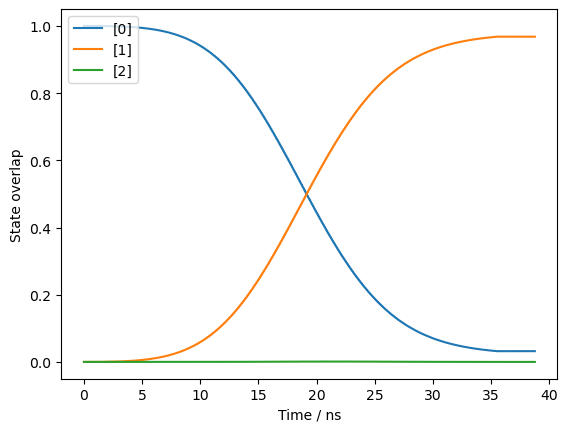

In [11]:
overlaps = simulation_engine.compute_overlaps(simulated_states)

from qibolab_visualization.emulator import plot_overlaps
plot_overlaps(overlaps,sim_time_list,time_label='Time / ns');

## Sampling and applying readout noise

By default, the 'readout_error' from the `'model_params'` dictionary is applied when generating the samples from simulation without noise:

In [12]:
samples = results[0].samples
samples[:20].tolist(), np.sum(samples)

([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1], 941)

Samples can be obtained from the final state of the simulation without applying readout error manually by the `get_samples` function:

In [13]:
final_state = simulated_states[-1]

from qibolab.instruments.emulator.pulse_simulator import get_samples
ro_qubit_list = [pulse_r0.qubit]
ro_reduced_dm, rdm_qubit_list = pulse_simulator.simulation_engine.qobj_to_reduced_dm(final_state, ro_qubit_list)
noiseless_samples = get_samples(1000, ro_reduced_dm, rdm_qubit_list, pulse_simulator.simulation_engine.qid_nlevels_map)

noiseless_samples[0][:20], np.sum(noiseless_samples[0])

([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1], 975)

The `readout_error` can be applied subsequently as well with the `apply_readout_noise` function:

In [14]:
from qibolab.instruments.emulator.pulse_simulator import apply_readout_noise

readout_error = {0: [0.1, 0.1], 1: [0.1, 0.1]}
noisy_samples = apply_readout_noise(noiseless_samples, readout_error)
noisy_samples[0][:20], np.sum(noisy_samples[0])

([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1], 862)

## Returning only the final state of simulations

In some cases, the entire history of the simulated states is not needed. One can save memory by setting `'output_state_history' = 'False'`in `'simulations_config'`. This is useful for instance when running sweepers:

In [15]:
from qibolab.sweeper import Sweeper, Parameter

parameter = Parameter.duration
parameter2 = Parameter.amplitude
parameter_range = np.linspace(155/4.5, 165/4.5, num=3)
parameter2_range = np.linspace(0.23045125169257026, 0.25045125169257026, num=3)
sweeper = Sweeper(parameter, parameter_range, [pulse_x0])
sweeper2 = Sweeper(parameter2, parameter2_range, [pulse_x0])

In [16]:
# output only final state
emulator_platform.instruments['pulse_simulator'].output_state_history = False
sweep_results = emulator_platform.sweep(sequence, ExecutionParameters(), sweeper, sweeper2)

[Qibo 0.2.6|INFO|2024-05-23 18:32:51]: Minimal execution time (sweep): 11.24409344
INFO:qibo.config:Minimal execution time (sweep): 11.24409344


sweep param: duration
values [34.44444444 35.55555556 36.66666667]
sweep param: amplitude
values [0.23045125 0.24045125 0.25045125]
 Total run time:   1.31s*] Elapsed 1.31s / Remaining 00:00:00:00
 [*********58%*          ] Elapsed 0.99s / Remaining 00:00:00:00[*****    22%           ] Elapsed 0.33s / Remaining 00:00:00:01[*****    22%           ] Elapsed 0.35s / Remaining 00:00:00:01

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   1.30s*] Elapsed 1.30s / Remaining 00:00:00:00
sweep param: amplitude
values [0.23045125 0.24045125 0.25045125]
 Total run time:   1.33s*] Elapsed 1.33s / Remaining 00:00:00:00
 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:01

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   1.78s*] Elapsed 1.78s / Remaining 00:00:00:00
 Total run time:   2.38s*] Elapsed 2.38s / Remaining 00:00:00:00[*********53%           ] Elapsed 1.06s / Remaining 00:00:00:00[*********62%**         ] Elapsed 1.45s / Remaining 00:00:00:00[*********82%*******    ] Elapsed 2.08s / Remaining 00:00:00:00
sweep param: amplitude
values [0.23045125 0.24045125 0.25045125]
 [*********65%***        ] Elapsed 0.91s / Remaining 00:00:00:00[*****    21%           ] Elapsed 0.24s / Remaining 00:00:00:00

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   1.50s*] Elapsed 1.50s / Remaining 00:00:00:00
 [*********42%           ] Elapsed 0.58s / Remaining 00:00:00:00

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   1.37s
 Total run time:   1.44s*] Elapsed 1.44s / Remaining 00:00:00:00[****     16%           ] Elapsed 0.23s / Remaining 00:00:00:01


To help visualize the simulation results, we can once again look at its overlap with the basis states of the system. We use `make_array_index_list` function to generate a list of all possible index combinations of an array with arbitrary shape, in this case corresponding to all possible combinations of different sweeper parameters:

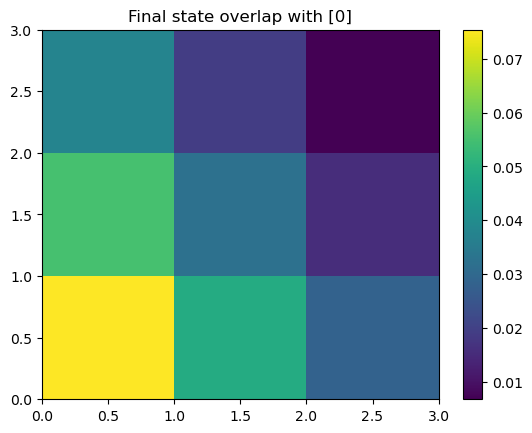

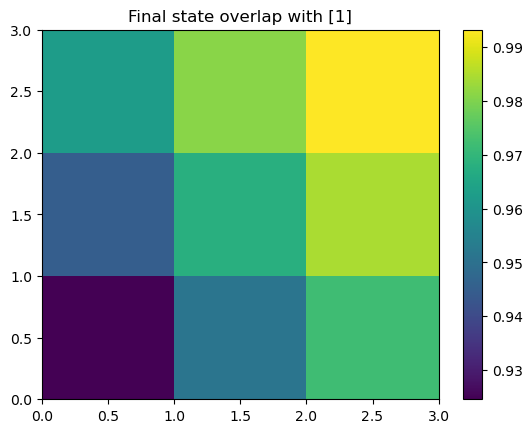

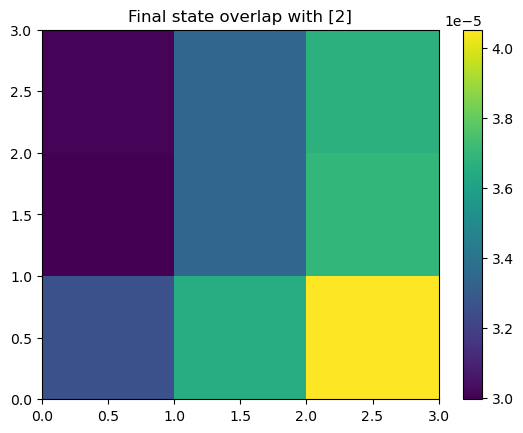

In [17]:
from qibolab.instruments.emulator.pulse_simulator import make_array_index_list

final_states_array = sweep_results['simulation']['output_states']
shape = final_states_array.shape
index_list = make_array_index_list(shape)
overlaps = {}
for index in index_list:
    pulse_simulator.merge_sweep_results(overlaps, simulation_engine.compute_overlaps(final_states_array[tuple(index)]))

import matplotlib.pyplot as plt
for label in overlaps.keys():
    plt.figure()
    plt.pcolormesh(np.array(overlaps[label]).reshape([3,3]))
    plt.colorbar()
    plt.title(f'Final state overlap with {label}')
    plt.show()

## --- Version information for major packages used in the current Qibolab emulator example ---

In [18]:
%load_ext watermark

In [19]:
%watermark -v -p qibolab,qibo,qutip,matplotlib,numpy,scipy

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.15.0

qibolab   : 0.1.6
qibo      : 0.2.6
qutip     : 4.7.5
matplotlib: 3.8.0
numpy     : 1.26.4
scipy     : 1.12.0

